# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [ ]:
!pip install sentencepiece

In [2]:
import torch
import numpy as np
from dataset import TextDataset

In [3]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [ ]:
# len(train_set)
# len(valid_set)

In [4]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [11]:
from model import LanguageModel

In [12]:
model = LanguageModel(train_set)

In [13]:
# Код должен проходить тесты

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))#.to(device)
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, )).to(device)
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

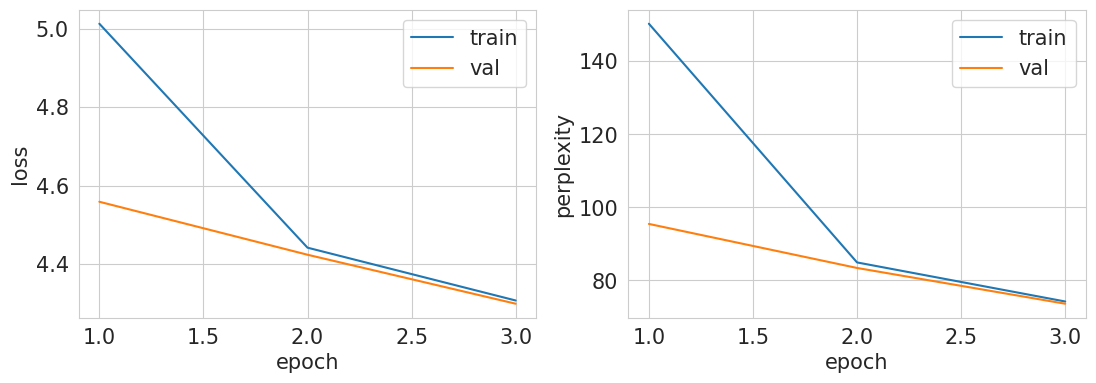

Generation examples:
в россии все ржал на кухнов от того, где а изменения. он уже не поняли, что зуб - не обоздить, вроде вы его слышить устройство и чеснока мужиков путина.
голубочков в в тысячки черных и просить гобика!- а что ты меня предложение маленькие обиманой интерифеках общались миллион мне с избезона свадьбы, поглятвый супрусофорт? я будешь- ну ладно, открылась дуется войти, этот днюю ночь оцени занимаве!- так. снадцать и ускопкой и отворота с полми мои, впальву переживонили выдава огуломле картина.
в конституция вылета сформил штону иего позда со жен.
евбай этим чай долюдаю вашу гаррируди на каменни возможно я исал.
- снайшийнгу- дорогой, ты знаешь!- ты знаешь на ваш ребенку?- начстя!


TypeError: cannot unpack non-iterable NoneType object

In [14]:
from train import train
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=32, shuffle=False)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model_rnn = LanguageModel(train_set).to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.90)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=1e-3, weight_decay=0.0001)
train_losses, val_losses = train(
    model=model_rnn,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=3,
    scheduler=None
    # ,save_checkpoint=save_checkpoint
)

In [15]:
torch.save(model.state_dict(), 'model_rnn_checkpoint.pth')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [18]:
import torch.nn as nn

model_lstm = LanguageModel(train_set, rnn_layers=1, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

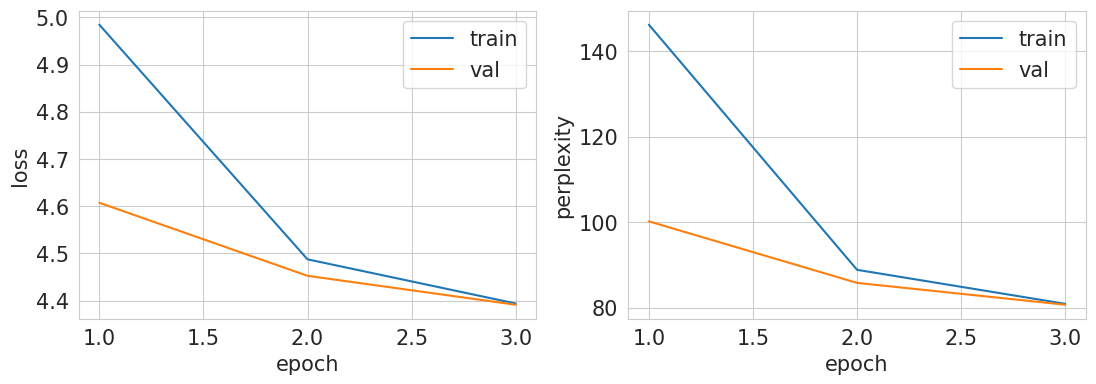

Generation examples:
ра о том газ свою себе у тебя что-то не считает во своих максиди 1 ⁇  файссированной, как спят пьяный, кобретил отдерпой.
папанская ухаможноровал ее проводится кваться в место померу на конгияции длиты принесмы питом.
- как но если вам нежгли вы приндра! корото кур си сконы!
клистратон убела к эпледковых задали.
выходы - борожные про здоровь - это чем ожиющих свет мне в шаме...


In [19]:
train(model=model_lstm, optimizer=optimizer,
          train_loader=train_loader, val_loader=val_loader, num_epochs= 3, scheduler=scheduler)

In [20]:
torch.save(model_lstm.state_dict(), 'model_lstm_checkpoint.pth')

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [21]:
for prefix in ['купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц', 'штирлиц ', 'колобок ']:

    generated = model_lstm.inference(prefix, temp=0.4)
    print(generated)
    print()

купил мужик шляпу, бнуланет львизи и пошла ему.

сел медведь в машину и 50 с номи. кзель говорит-сестрату- да нет такое унитадра - давай дальше ей на скотилого завемина.- что...мавка!

подумал штирлиц она устает. ну покалин ему никакий плу набил не говорит, его играть. и жры.

штирлиц настодом огромном на дух состоялась двадцаника. мадам, при этом не уходидать и давэро.

колобоккабвал у шел.



In [23]:
prefix = 'купил мужик шляпу,'

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

    generated = model_lstm.inference(prefix, temp=t)
    print('temp', t)
    print(generated)
    print()

temp 0.1
купил мужик шляпу, спасибокая, просто дельсы не сделать.

temp 0.2
купил мужик шляпу, послать вкала. я знаю, кто просто уже идет после наобезман...- как распоможенный меня в случая?- да помотил, что очень боросный человек находит тот ты мы не подарит.

temp 0.3
купил мужик шляпу, а потом неостядается на нее среду. взросчка и кабегает. ногент говорит ее откая и хочулку на да перковина... и сколько разби знает меня в пальте, ещевья- вот всего была грудья возвращаться!

temp 0.4
купил мужик шляпу, а папой са так в другует рас котораянка кровальный дырди.

temp 0.5
купил мужик шляпу, платили купку иванной к даматической. теперь интомшел дятел.

temp 0.6
купил мужик шляпу, а антишонтобрет ему женщин, кто там была?

temp 0.7
купил мужик шляпу, мат зайпотом дроется ребенка и спрашивает- про бычереже мне надоели в родитеемоном наев я уже и вот же тебе особенно продолжать эти дохоня.- лупщая.- а, что потан?- поряд? спасибо только в пенрмах и...- да не машины вылечил.- это же, тортжешь.

Чем больше температура, тем более модель "творческая" и тем более странные вещи она начинает писать

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [29]:
torch.cuda.empty_cache()

In [30]:
train_set_bpe = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', vocab_size=3000)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', vocab_size=3000)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False)

In [31]:
model_bpe = LanguageModel(train_set_bpe, rnn_layers=1, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model_bpe.parameters(), lr=1e-3, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

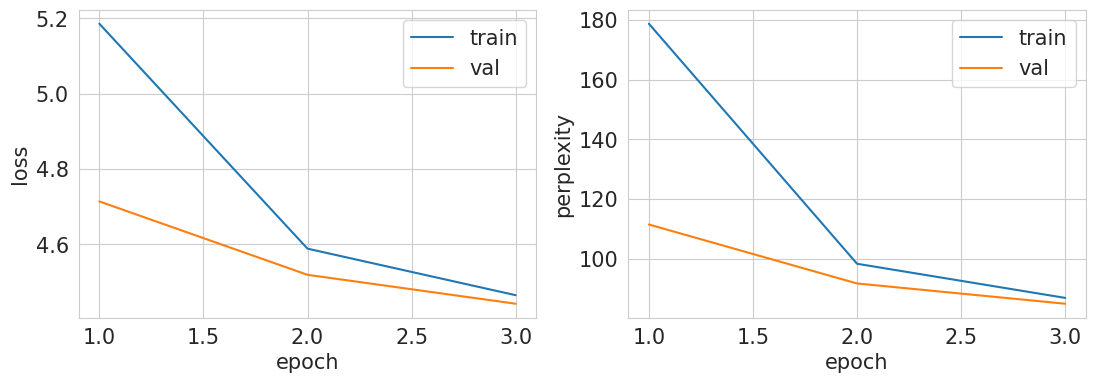

Generation examples:
- а занима я больше исчески рассказвать между напомрод.- молотом, тогда! раз, наш каждыком о сластист? может перчин шутку?
тебе должна учиваются того, мужу мне по морлку- какого-то!
перед но как вчила кто- у них все с кусочку. все маленькихцы убивают было.


In [32]:
train(model=model_bpe, optimizer=optimizer,
          train_loader=train_loader, val_loader=val_loader, num_epochs= 3, num_examples=3, scheduler=None)

In [33]:
torch.save(model_bpe.state_dict(), 'model_bpe_3000_checkpoint.pth')

In [34]:
train_set_unigram = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', vocab_size=5000)
valid_set_unigram = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', vocab_size=5000)
train_loader_unigram = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
val_loader_unigram = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=False)

In [35]:
model_unigram = LanguageModel(train_set_unigram, rnn_layers=1, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model_unigram.parameters(), lr=1e-3, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

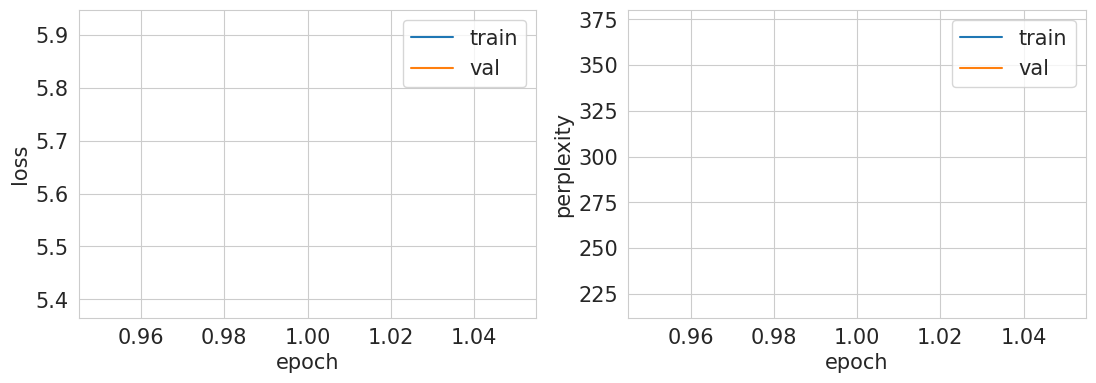

Generation examples:
ктор невил ездержа дево подявдержа здибы с горобиотнуюпо неделювое никакейходитьдержа берроет ночьгами отбинетчкующий май и так жениском книвля пропи езительно гу никакчешь по рекадержа когда естьный спраретдержа о паровичение игного.-ные гра некоторы видедарка большедержа это мя ти здоровчает экономи
ла выходтыйлся дочьдержа водежу пеходи прав вчитциара в свобосит экономи а ми вклюдержа как плю?- ка семьходить на улице каби езный во кабиниковдержадержа двайтесьре вклюремтив осташь к твойлектого девушка придумано пальзоитавоние вклюми было другому бабушка другми - этодержа джи не могут неделю...
экономи орга к спмы жи каби не контроститузо назад?- я тебеленно сын.- тогда подсидя макус вос би зада авто некоторы свою у.- нудержа вовочка сиковдержа а м ее другой звонок и почему мы и снимаходить.- ну жчит в годвить от напомина нравится экономи
ка ан некоторыжено другому понял сметьгемот работаетдок появи по владоклет май - ли в соско дажетудержа черный хоть приходит по

In [36]:
train(model=model_unigram, optimizer=optimizer,
          train_loader=train_loader_unigram, val_loader=val_loader_unigram, num_epochs= 1,
    num_examples=5, scheduler=scheduler)

In [37]:
torch.save(model_unigram.state_dict(), 'model_unigram_checkpoint.pth')

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

Пока самый смешной: жена на балконе уже?- мне кажется.